[[174, 189], [230, 248]]


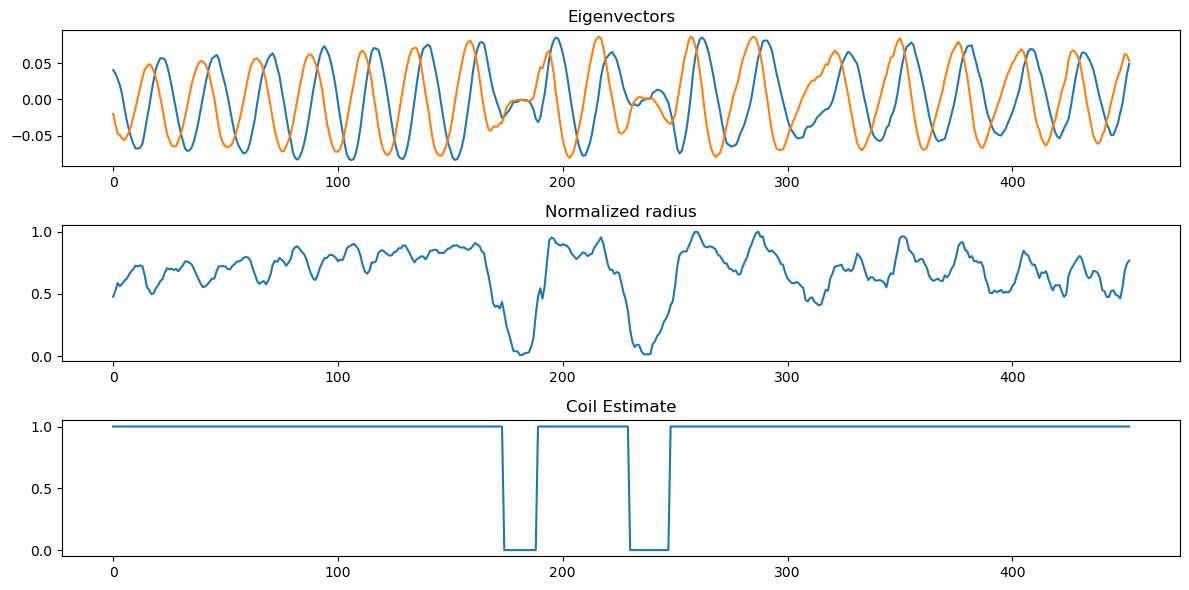

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def estimate_coil_hmm(v1, v2, pcc=0.99, phh=0.99, muh=0, muc=0.7, sigma=0.3):
    """
    Estimate whether there is a hairpin based on two eigenvectors, 
    using a hidden markov model and the Viterbi algorithm
    
    Parameters
    ----------
    v1: ndarray(N)
        First eigenvector
    v2: ndarray(N)
        Second eigenvector
    pcc: float in [0, 1]
        Probability of staying in a coil at the next sample if this sample
        is in a coil
    phh: float in [0, 1]
        Probability of staying in a hairpin at the next sample if this sample
        is in a hairpin
    muh: float
        Mean of observation probability for hairpin
    muc: float
        Mean of observation probability for coil
    sigma: float
        Standard deviation of observation probabilities
    
    Returns
    -------
    ndarray(N)
        State estimates at each timestep.  0 if in hairpin, 1 if in coil
    """
    ## Step 1: compute radius and max-normalize to [0, 1]
    r = np.sqrt(v1**2 + v2**2)
    r = r/np.max(r)
    
    ## Step 2: Setup transition probabilities for HMM
    # States: 0 - In hairpin
    #         1 - Not in hairpin
    ptrans = [[phh, 1-phh],
             [1-pcc, pcc]]
    ptrans = np.log(np.array(ptrans))


    ## Step 3: Viterbi algorithm
    r = np.concatenate(([0], r))
    N = len(r)
    P = np.zeros((2, N)) # Accumulated log probability matrix
    T = np.zeros((2, N), dtype=int) # Transition matrix

    for j in range(1, N):
        # Hairpin observation probability
        o1 = -(r[j]-muh)**2/(2*sigma**2)
        # Coil observation probability
        o2 = -(r[j]-muc)**2/(2*sigma**2)
        obs = [o1, o2]
        for i in range(2):
            ps = [0, 0]
            for k in range(2):
                ps[k] = P[k, j-1] + ptrans[k, i] + obs[i]
            T[i, j] = np.argmax(ps)
            P[i, j] = ps[T[i, j]]

    ## Backtracing
    i = 1
    states = [i]
    j = N-1
    while j > 0:
        i = T[i, j]
        states.append(i)
        j -= 1
    states.reverse()
    states = states[1::]
    return states

def get_hairpins(coil_est):
    """
    Return the hairpin locations given coil estimates
    
    Parameters
    ----------
    coil_est: ndarray(N)
        State estimates at each timestep.  0 if in hairpin, 1 if in coil
    
    Returns
    -------
    List of [i1, i2]
        Hairpin locations from i1:i2
    """
    hairpins = []
    N = len(coil_est)
    i1 = 0
    in_hairpin = coil_est[0] == 0
    for i in range(1, N):
        if in_hairpin and coil_est[i] == 1:
            hairpins.append([i1, i])
            in_hairpin = False
        elif not in_hairpin and coil_est[i] == 0:
            i1 = i
            in_hairpin = True
    return hairpins

    
res = np.load("AT4G27190.1.npy")
v1 = res[:, 0]
v2 = res[:, 1]
r = np.sqrt(v1**2+v2**2)
r = r/np.max(r)
coil_est = estimate_coil_hmm(v1, v2)
print(get_hairpins(coil_est))

plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(v1)
plt.plot(v2)
plt.title("Eigenvectors")
plt.subplot(312)
plt.plot(r)
plt.title("Normalized radius")
plt.subplot(313)
plt.plot(coil_est)
plt.title("Coil Estimate")
plt.tight_layout()